### Training

In [31]:
from diffmd.solvers import odeint_adjoint

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
import shutil
import quaternion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f'Using {device} device')

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.log(val)
    
    def log(self, val):
        self.losses.append(val)

def get_first_batch(trajs,nsample,sampleLength,dt):
    twice_dim = trajs.size()[2]
    dim = twice_dim//2
    
    q0 = trajs[0:nsample, 0, :dim].to(device)
    p0 = trajs[0:nsample, 0, dim:].to(device)
    batch_y0 = (p0, q0)
    
    q = trajs[0:nsample, 0:sampleLength, :dim].to(device)
    p = trajs[0:nsample, 0:sampleLength, dim:].to(device)
    batch_y = torch.cat((p, q), dim=2).swapaxes(0, 1)
    
    batch_t = torch.linspace(0.0,dt*(sampleLength-1),sampleLength).to(device)
    return batch_t, batch_y0, batch_y

class ODEFunc(nn.Module):
    def __init__(self, dim, width, depth):
        super(ODEFunc, self).__init__()
        self.dim = dim
        
        layers = []
        for i in range(depth):
            if i == 0:
                layers += [nn.Linear(self.dim, width), nn.Sigmoid()]
            if i == (depth-1):
                layers += [nn.Linear(width, self.dim)]
            else:
                layers += [nn.Linear(width, width), nn.Sigmoid()]
        self.net = nn.Sequential(*layers)
        
        for m in self.net.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)

        # HACK ???
        m = 1.0
        self.mass = m*m/(m+m)

    def forward(self, state):
        
        with torch.set_grad_enabled(True):        
            
            v = state[0]
            q = state[1]
            
            q.requires_grad = True
            
            f = -self.compute_grad(q, 0.01)
            dvdt = f / self.mass
            dqdt = v
            
        return (dvdt, dqdt)

    def compute_grad(self, q, dq):
        # using this over compute_grad from nff seems to make no difference
        # HACK: does this only work with q_n => n=1? 
        return (self.net(q+dq) - self.net(q-dq)) / (2 * dq)

def get_data():
    # train_split = 0.9
    # test_split = 1 - train_split
    df = pd.read_csv(file_name+'-reduced_traj.csv')
    # HACK: do this based on the column names, not explicitly
    com = ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]', 'c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']
    q = ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', 'c_q_1[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', 'c_q_2[4]']
    vel = ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]', 'c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]'] 
    av = ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]', 'c_av_2[1]', 'c_av_2[2]', 'c_av_2[3]']
    am = ['c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]', 'c_am_2[1]', 'c_am_2[2]', 'c_am_2[3]']
    
    centre_of_masses = df.loc[:, ['timestep', *com]]
    quaternions = df.loc[:, ['timestep', *q]]
    velocities = df.loc[:, ['timestep', *vel]]
    ang_velocities = df.loc[:, ['timestep', *av]]
    ang_momenta = df.loc[:, ['timestep', *am]]
    
    # TODO: use DataLoaders?
    
    # trajs = np.load('data/trajectories/diatomic_spring_narrow.npy')
    # split_index = int(trajs.shape[0] * train_split)

    # np.random.shuffle(trajs)
    # training_trajs = torch.Tensor(trajs[:split_index, :, :]).to(device)
    # testing_trajs = torch.Tensor(trajs[split_index:, :, :]).to(device)
    
    return centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta

def process_data(centre_of_masses, quaternions, velocities, ang_velocities):
    # TODO: have a 'reduce' possibility that reduces, or does not reduce the coordinates 
    # HACK: for now take all the variables, do not reduce anything
    
    # HACK: send a single trajectory
    ntraj = 1
    
    # # Get separation between centre of masses
    com1 = centre_of_masses.loc[:, ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]']].to_numpy()
    com2 = centre_of_masses.loc[:, ['c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']].to_numpy()
    # separation = np.linalg.norm(com1-com2, axis=1).reshape(-1, 1)
    coms = torch.from_numpy(np.hstack((com1, com2))).to(device).view(ntraj, -1, 6)
    
    # # Get difference between rotations
    quat1 = quaternions.loc[:, ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', "c_q_1[4]"]].to_numpy()
    quat2 = quaternions.loc[:, ['c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', "c_q_2[4]"]].to_numpy()
    # quat_transition = quaternion.as_float_array(quat2 * quat1.conjugate())
    quats = torch.from_numpy(np.hstack((quat1, quat2))).to(device).view(ntraj, -1, 8)
    
    # # Get translation velocities
    vel1 = velocities.loc[:, ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]']].to_numpy()
    vel2 = velocities.loc[:, ['c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]']].to_numpy() 
    # vel_diff = vel2 - vel1 
    vels = torch.from_numpy(np.hstack((vel1, vel2))).to(device).view(ntraj, -1, 6)
    
    # Get angular velocities
    ang_vels = torch.from_numpy(ang_velocities.iloc[:, 1:].to_numpy()).to(device).view(ntraj, -1, 6)
    
    # return (np.hstack((vel_diff, ang_velocities)), np.hstack((separation, quat_transition)))
    return (vels, ang_vels, coms, quats)



Using cuda device


In [53]:
file_name = 'hexagons/trajectories/NVE-temp-0.1_sig-2_cut-1.5_K-0.1_r-5'

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta = get_data()

trajectory = process_data(centre_of_masses, quaternions, velocities, ang_velocities)

def get_batch_mod(traj,batch_size,batch_length,dt):
    
    vel_dim = trajectory[0].size()[2]
    angvel_dim = trajectory[1].size()[2]
    com_dim = trajectory[2].size()[2]
    quat_dim = trajectory[3].size()[2]

    sampled_is = torch.randint(traj[0].shape[0],size = (batch_size,)).to(device)
    sampled_js = torch.randint(traj[0].shape[1]-batch_length,size = (batch_size,)).to(device)
    initial_time = sampled_js*dt
    
    batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length).to(device)
    
    vels = traj[0][sampled_is,sampled_js,:]
    ang_vels = traj[1][sampled_is,sampled_js,:]
    coms = traj[2][sampled_is,sampled_js,:]
    quats = traj[3][sampled_is,sampled_js,:]
    
    pos_init = (vels, ang_vels, coms, quats)

    sampled_trajs = []
    
    for i in range(batch_size):
        vels = traj[0][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:].view(-1,vel_dim)
        ang_vels = traj[1][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:].view(-1,angvel_dim)
        coms = traj[2][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:].view(-1,com_dim)
        quats = traj[3][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:].view(-1,quat_dim)
        x = torch.cat((vels, ang_vels, coms, quats), dim=1)
        sampled_trajs.append(x)
        
    batch_trajs = torch.stack(sampled_trajs,dim=1)
    batch_trajs = torch.split(batch_trajs, [vel_dim, angvel_dim, com_dim, quat_dim], dim=2)
    return batch_t, pos_init, batch_trajs



niters = 1000
nn_width = 25
nn_depth = 2
learning_rate = 1e-3

loss_meter = RunningAverageMeter()
dim = (trajectory[2].size()[2]) + (trajectory[3].size()[2]) # add number of quaternions and centre of masses degrees of freedom
func = ODEFunc(dim, nn_width, nn_depth).to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=learning_rate)

for itr in range(1, niters + 1):
    start = time.perf_counter()
    optimizer.zero_grad()
    
    # HACK: to try sending in a trajectory
    batch_t, batch_y0, batch_y = get_batch_mod(trajectory, 100, 10, 0.0005)
    
    # # convert momentum to velocity (v = p / mu)
    # batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
    pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

    # convert velocity to momentum (p = mu * v)
    # pred_y = (pred_y[0] * func.mass, pred_y[1])
    pred_y = torch.cat(pred_y, dim=2)
    
    loss = torch.mean(torch.abs(pred_y[:, :, 0] - batch_y[:, :, 0]))
    loss.backward() 
    optimizer.step()
    loss_meter.update(loss.item())
    
    if itr % 10 == 0: # output log throughout
        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
        print('current loss: {:.4f}'.format(loss_meter.val))
        print('Last iteration took: ', time.perf_counter() - start)


ValueError: received 4 argumets integration, but should be 2 for the forward call or 5 for the backward call

In [5]:
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()

In [11]:
print(trajectory)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01518218, -0.0139471 ,  0.01710846, ..., -0.0215073 ,
        -0.0290482 , -0.00088951],
       [-0.02682069,  0.0195529 , -0.06787774, ..., -0.173707  ,
        -0.0441775 , -0.0367169 ],
       ...,
       [-0.0213354 ,  0.277402  , -0.0801334 , ...,  0.099064  ,
         0.111093  ,  0.0802596 ],
       [-0.0109809 ,  0.315444  , -0.1316132 , ...,  0.0687512 ,
         0.115968  ,  0.0391946 ],
       [ 0.0974403 ,  0.292485  , -0.0782197 , ...,  0.00388676,
         0.0939857 , -0.0465734 ]]), array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.44322943e+00,  9.99824108e-01, -4.29189831e-03,
        -1.81224667e-02, -2.07064793e-03],
       [ 2.42378183e+00,  9.99116925e-01, -4.32879377e-03,
        -3.99009689e-02,  1.23820525e-02],
       ...,
       [ 6.38621611e+00, -7.11082596e-01,  4.32012695e-01,
        

    index  timestep  body_id    id         x         y         z
0      28    1000.0      1.0   1.0  0.989920  0.005859 -0.020850
1      29    1000.0      1.0   2.0  0.495232  0.874905 -0.014301
2      30    1000.0      1.0   3.0 -0.504460  0.881011  0.009731
3      31    1000.0      1.0   4.0 -1.009460  0.018072  0.027215
4      32    1000.0      1.0   5.0 -0.514776 -0.850974  0.020666
5      33    1000.0      1.0   6.0  0.484916 -0.857080 -0.003366
6      34    1000.0      1.0   7.0 -0.009772  0.011965  0.003183
7      35    1000.0      2.0   8.0  2.005380  1.006250  2.004160
8      36    1000.0      2.0   9.0  1.503160  1.870960  1.996230
9      37    1000.0      2.0  10.0  0.503239  1.868330  1.984050
10     38    1000.0      2.0  11.0  0.005532  1.000990  1.979800
11     39    1000.0      2.0  12.0  0.507748  0.136286  1.987730
12     40    1000.0      2.0  13.0  1.507670  0.138914  1.999910
13     41    1000.0      2.0  14.0  1.005450  1.003620  1.991980
          x         y
0  

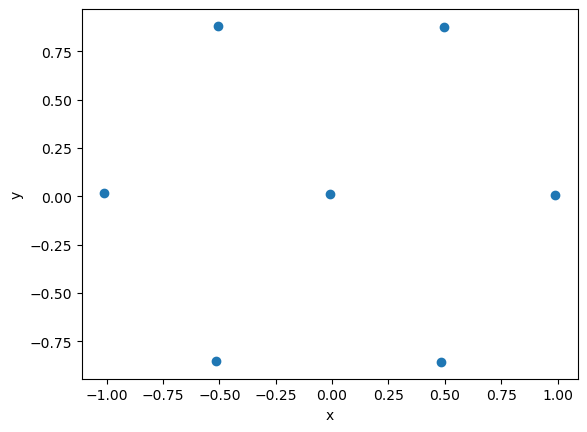

In [104]:
firstStep = orig_traj.loc[orig_traj['timestep'] == 1000].reset_index()
firstHexagon = firstStep.loc[:6, ['x', 'y']]
print(firstStep)
print(firstHexagon)
plt.plot(firstHexagon.iloc[:, 0], firstHexagon.iloc[:, 1], 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [24]:
quat1 = quaternions.iloc[:, 0:4].to_numpy()[1:]
ang_vel_1 = ang_velocities.iloc[:, 0:3].to_numpy()
ang_mom_1 = ang_momenta.iloc[:, 0:3].to_numpy()
# print(ang_vel_1)
# print(ang_mom_1)

inertia_1 = ang_mom_1[1:, :] / ang_vel_1[1:, :]
# for i in range(100):
    # print(inertia_1[i])

# quaternion vectors are normalised
# print(np.linalg.norm(quat1[:, 1:], axis=1))



# quaternion package
# print(quat1.shape)
quat1 = quaternion.as_quat_array(quat1)
# print(quat1[0])
# print(quaternion.as_rotation_matrix(quat1)[0])
q = quat1[0]
R = quaternion.as_rotation_matrix(quat1)[0]
# print(q)
vector1 = np.array([2.5, 3.6, 3.7])
vector1_Q = np.quaternion(0, 2.5, 3.6, 3.7)
vector2_R = R @ vector1
vector2_Q = q * vector1_Q * q.conjugate()


# print(q)
# print(q.conjugate())
# print(R.shape)

print(vector2_Q)
print(quaternion.as_float_array(vector2_Q))


vector_plot([vector1, vector2_R, quaternion.as_float_array(vector2_Q)[1:]])




quaternion(6.93889390390723e-18, -2.38796216413147, -3.63768324282903, 3.73695904748035)
[ 6.93889390e-18 -2.38796216e+00 -3.63768324e+00  3.73695905e+00]


In [51]:
quat1 = quaternions.iloc[:, 0:4].to_numpy()[1:]
quats = quaternion.as_quat_array(quat1[:10])
# consider quaternions to be a rotation from x axis
vector = np.quaternion(0, 1, 0, 0)
print(vector)
vector = quats * vector * quats.conjugate()

# print(quats)
# print(quats.conjugate())
vectors = quaternion.as_float_array(vector)[:, 1:]
# plots subsequent orientations
vector_plot(list(vectors))
print(list(vectors))

quaternion(0, 1, 0, 0)


[array([-0.99969073, -0.00631347,  0.0240322 ]), array([-0.99908286,  0.00160399,  0.04277968]), array([-0.99706856,  0.02358701,  0.07279627]), array([-0.99604604,  0.03336901,  0.08234398]), array([-0.99751062,  0.04460248,  0.05461585]), array([-0.99677454,  0.07958029,  0.01032569]), array([-0.99301676,  0.11074407, -0.04067183]), array([-0.99175207,  0.09744422, -0.08325662]), array([-0.99261598,  0.07128534, -0.09814727]), array([-0.99204744,  0.09161861, -0.08629929])]


In [ ]:
def get_batch_mod(traj,batch_size,batch_length,dt):

  twice_dim = traj.size()[2]
  dim = twice_dim//2
  sampled_is = torch.randint(traj.shape[0],size = (batch_size,)).to(device)
  sampled_js = torch.randint(traj.shape[1]-batch_length,size = (batch_size,)).to(device)
  initial_time = sampled_js*dt

  batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length).to(device)
  qs = traj[sampled_is,sampled_js,:dim]
  ps = traj[sampled_is,sampled_js,dim:]
  pos_init = (ps, qs)
  # print('p', ps)
  # print('q', qs)

  sampled_trajs = []

  for i in range(batch_size):
      qs = traj[sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:dim].view(-1,dim)
      ps = traj[sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,dim:].view(-1,dim)
      x = torch.cat((ps, qs), dim=1)
      sampled_trajs.append(x)

      
  batch_trajs = torch.stack(sampled_trajs,dim=1)
  return batch_t,pos_init,batch_trajs
     

def get_data():
    train_split = 0.9
    test_split = 1 - train_split
    trajs = np.load('data/trajectories/diatomic_spring_narrow.npy')
    split_index = int(trajs.shape[0] * train_split)

    np.random.shuffle(trajs)
    training_trajs = torch.Tensor(trajs[:split_index, :, :]).to(device)
    testing_trajs = torch.Tensor(trajs[split_index:, :, :]).to(device)
    
    return training_trajs, testing_trajs 

def train_model(niters, training_trajs, dt, sample_length, batch_size, learning_rate, nn_depth, nn_width):    
    loss_meter = RunningAverageMeter()
    dim = training_trajs.size()[2] // 2
    func = ODEFunc(dim, nn_width, nn_depth).to(device)
    optimizer = torch.optim.Adam(func.parameters(), lr=learning_rate)

    for itr in range(1, niters + 1):
        start = time.perf_counter()
        optimizer.zero_grad()
        
        batch_t, batch_y0, batch_y = get_batch_mod(training_trajs, batch_size, sample_length,dt)
        
        # convert momentum to velocity (v = p / mu)
        batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
        pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

        # convert velocity to momentum (p = mu * v)
        pred_y = (pred_y[0] * func.mass, pred_y[1])
        pred_y = torch.cat(pred_y, dim=2)
        
        loss = torch.mean(torch.abs(pred_y[:, :, 0] - batch_y[:, :, 0]))
        loss.backward() 
        optimizer.step()
        loss_meter.update(loss.item())
        
        if itr % 10 == 0: # output log throughout
            print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
            print('current loss: {:.4f}'.format(loss_meter.val))
            print('Last iteration took: ', time.perf_counter() - start)

    return func, loss_meter

def test_model(func, testing_trajs, dt):    
    loss_meter = RunningAverageMeter()
    batch_size = testing_trajs.shape[0]
    sample_length = testing_trajs.shape[1]
    batch_t, batch_y0, batch_y = get_first_batch(testing_trajs, batch_size, sample_length, dt)
        
    # convert momentum to velocity (v = p / mu)
    batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
    pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

    # convert velocity to momentum (p = mu * v)
    pred_y = (pred_y[0] * func.mass, pred_y[1])
    pred_y = torch.cat(pred_y, dim=2)
    
    loss = torch.mean(torch.abs(pred_y[:, :, 0] - batch_y[:, :, 0]))
    loss_meter.update(loss.item())
    
    return loss_meter

def evaluate_model(sample_length, batch_size, learning_rate, nn_depth, nn_width, activation_function):
    niters = 300
    dt = 0.1
    t0 = time.perf_counter()

    training_trajs, testing_trajs = get_data()
    model, train_loss = train_model(niters, training_trajs, dt, sample_length, batch_size, learning_rate, nn_depth, nn_width)
    training_time = time.perf_counter() - t0

    test_loss = test_model(model, testing_trajs, dt)

    training_and_testing_time = time.perf_counter() - t0
    return train_loss, test_loss, training_time, training_and_testing_time


import sigopt

def run_and_track_in_sigopt():

#   sigopt.log_dataset(DATASET_NAME)
#   sigopt.log_metadata(key="Dataset Source", value=DATASET_SRC)
#   sigopt.log_metadata(key="Feature Eng Pipeline Name", value=FEATURE_ENG_PIPELINE_NAME)
#   sigopt.log_metadata(
#     key="Dataset Rows", value=features.shape[0]
#   )  # assumes features X are like a numpy array with shape
#   sigopt.log_metadata(key="Dataset Columns", value=features.shape[1])
#   sigopt.log_metadata(key="Execution Environment", value="Colab Notebook")
  sigopt.log_model('Neural ODE Simple Harmonic Motion')
  learning_rates = [10**i for i in range(-5, 1)]
  sigopt.params.setdefaults(
    sample_length=np.random.randint(low=3, high=50),
    batch_size=np.random.randint(low=10, high=1000),
    learning_rate=np.random.choice(learning_rates),
    nn_depth=np.random.randint(low=1, high=5),
    nn_width=np.random.randint(low=2, high=50),
    # activation_function=,  
  )

  args = dict(
    sample_length=sigopt.params.sample_length,
    batch_size=sigopt.params.batch_size,
    learning_rate=sigopt.params.learning_rate,
    nn_depth=sigopt.params.nn_depth,
    nn_width=sigopt.params.nn_width,
    activation_function=None,
  )

  train_loss, test_loss, training_time, training_and_validation_time = evaluate_model(**args)

  running_avg_train_loss = train_loss.avg
  running_avg_test_loss = test_loss.avg

  sigopt.log_metric(name="train_loss", value=running_avg_train_loss)
  sigopt.log_metric(name="test_loss", value=running_avg_test_loss)
  sigopt.log_metric(name="training time (s)", value=training_time)
  sigopt.log_metric(name="training and validation time (s)", value=training_and_validation_time)

run_and_track_in_sigopt()